# Install PyTorch

PyTorch is a popular deep learning library known for its flexibility and ease of use. Here we'll learn how computations are represented and how to define a simple neural network in PyTorch. For all the labs in Introduction to Deep Learning 2025, there will be a PyTorch version available.

In [1]:
import torch
import torch.nn as nn

# Download and import the MIT Introduction to Deep Learning package
import mitdeeplearning as mdl

import numpy as np
import matplotlib.pyplot as plt

# What is PyTorch?

PyTorch is a machine learning library, like TensorFlow. At its core, PyTorch provides an interface for creating and manipulating tensors, which are data structures that you can think of as multi-dimensional arrays. Tensors are represented as n-dimensional arrays of base datatypes such as a string or integer -- they provide a way to generalize vectors and matrices to higher dimensions. PyTorch provides the ability to perform computation on these tensors, define neural networks, and train them efficiently.

The shape of a PyTorch tensor defines its number of dimensions and the size of each dimension. The ndim or dim of a PyTorch tensor provides the number of dimensions (n-dimensions) -- this is equivalent to the tensor's rank (as is used in TensorFlow), and you can also think of this as the tensor's order or degree.

In [2]:
integer = torch.tensor(1234)
decimal = torch.tensor(3.14159265359)

print(f"`integer` is a {integer.ndim}-d Tensor: {integer}")
print(f"`decimal` is a {decimal.ndim}-d Tensor: {decimal}")

`integer` is a 0-d Tensor: 1234
`decimal` is a 0-d Tensor: 3.1415927410125732


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Vectors and lists can be used to create 1-d tensors
fibonacci= torch.tensor([1,1,2,3,5,8])
count_to_100= torch.tensor(range(100))

print(f"`fibonacci` is a {fibonacci.ndim}-d Tensor with shape: {fibonacci.shape}")
print(f"`count_to_100` is a {count_to_100.ndim}-d Tensor with shape: {count_to_100.shape}")

`fibonacci` is a 1-d Tensor with shape: torch.Size([6])
`count_to_100` is a 1-d Tensor with shape: torch.Size([100])


Next, let’s create 2-d (i.e., matrices) and higher-rank tensors. In image processing and computer vision, we will use 4-d Tensors with dimensions corresponding to batch size, number of color channels, image height, and image width.

In [4]:
### Defining higher-order Tensors ###
'''TODO: Define a 2-d Tensor'''
matrix= torch.tensor([[1, 2, 3], [4, 5, 6]])

assert isinstance(matrix, torch.Tensor), "matrix must be a torch Tensor object"
assert matrix.ndim== 2

'''TODO: Define a 4-d Tensor'''
# Use torch.zeros to initialize a 4-d Tensor of zeros with size 10 x 3 x 256 x 256
# You can think of this as 10 images where each image is RGB 256 x 256.
images = torch.zeros(10, 3, 256, 256)  # Correctly initializing a 4D tensor

assert isinstance(images, torch.Tensor), "images must be a torch Tensor object"
assert images.ndim== 4, "images must have 4 dimensions"
assert images.shape== (10, 3, 256, 256), "images is in correct shape"

print(f"matrix is a {matrix.ndim}-d Tensor with shape: {matrix.shape}")
print(f"images is a {images.ndim}-d Tensor with shape: {images.shape}")

matrix is a 2-d Tensor with shape: torch.Size([2, 3])
images is a 4-d Tensor with shape: torch.Size([10, 3, 256, 256])


As you have seen, the shape of a tensor provides the number of elements in each tensor dimension. The shape is quite useful, and we'll use it often. You can also use slicing to access subtensors within a higher-rank tensor:

In [5]:
row_vector= matrix[1]
column_vector= matrix[:, 1]
scalar= matrix[0, 1]

print(f"`row_vector`: {row_vector}")
print(f"`column_vector`: {column_vector}")
print(f"`scalar`: {scalar}")

`row_vector`: tensor([4, 5, 6])
`column_vector`: tensor([2, 5])
`scalar`: 2


# Computations on Tensors

A convenient way to think about and visualize computations in a machine learning framework like PyTorch is in terms of graphs. We can define this graph in terms of tensors, which hold data, and the mathematical operations that act on these tensors in some order. Let's look at a simple example, and define this computation using PyTorch:

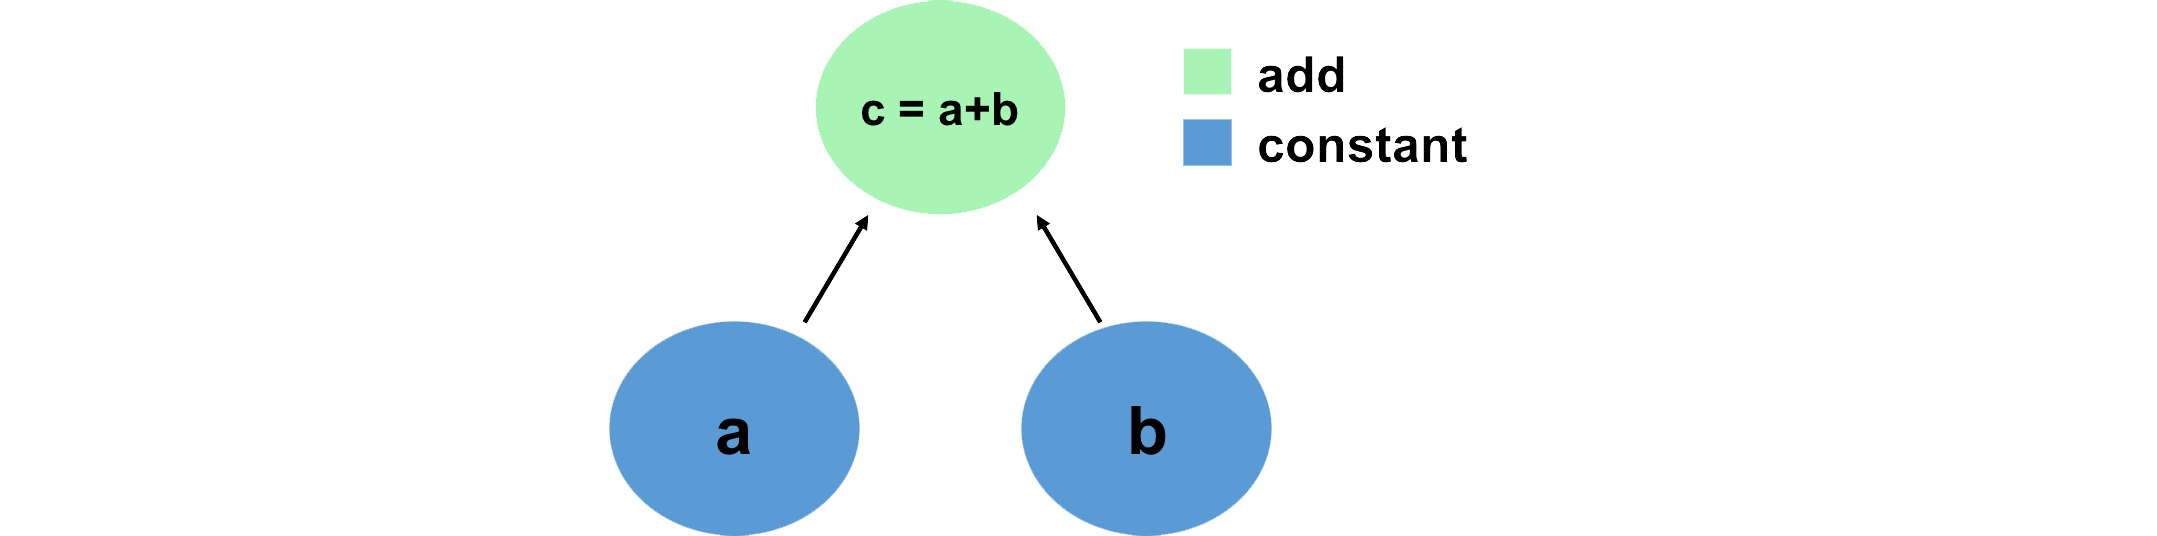

In [6]:
# create the nodes in the graph and initialize values
a= torch.tensor(15)
b= torch.tensor(61)

# add them
c1= torch.add(a, b)
c2= a + b # PyTorch overrides the "+" operation so that it is able to act on Tensors
print(f"c1: {c1}")
print(f"c2: {c2}")


c1: 76
c2: 76


Notice how we've created a computation graph consisting of PyTorch operations, and how the output is a tensor with value 76 -- we've just created a computation graph consisting of operations, and it's executed them and given us back the result.

Now let's consider a slightly more complicated example:

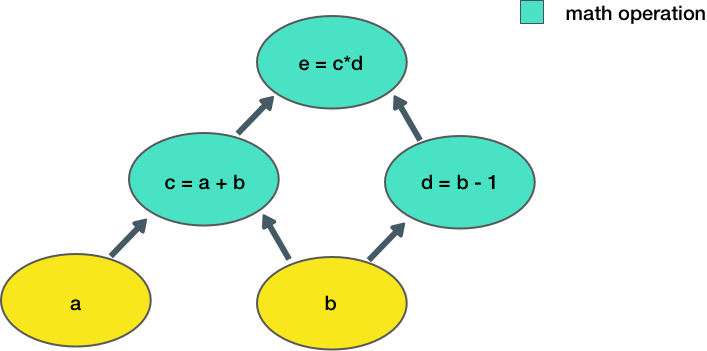

Here, we take two inputs, a, b, and compute an output e. Each node in the graph represents an operation that takes some input, does some computation, and passes its output to another node.

Let's define a simple function in PyTorch to construct this computation function:

In [7]:
# Defining Tensort computations

# construct a simple computation function
def fun(a, b):
    c= a+b
    d= b-1
    e= c*d
    return e

Now, we can call this function to execute the computation graph given some inputs a,b:

In [8]:
# consider the example
a, b= 10, 11
# execute the computation
e_out= fun(a, b)
print(f"e_out: {e_out}")

e_out: 210


Notice how our output is a tensor with value defined by the output of the computation, and that the output has no shape as it is a single scalar value.

# Neural networks in PyTorch

We can also define neural networks in PyTorch. PyTorch uses torch.nn.Module, which serves as a base class for all neural network modules in PyTorch and thus provides a framework for building and training neural networks.

Let's consider the example of a simple perceptron defined by just one dense (aka fully-connected or linear) layer: y= σ(Wx+b)
, where 
 W represents a matrix of weights, 
 b is a bias, 
 x is the input, 
 σ is the sigmoid activation function, and 
 y is the output.

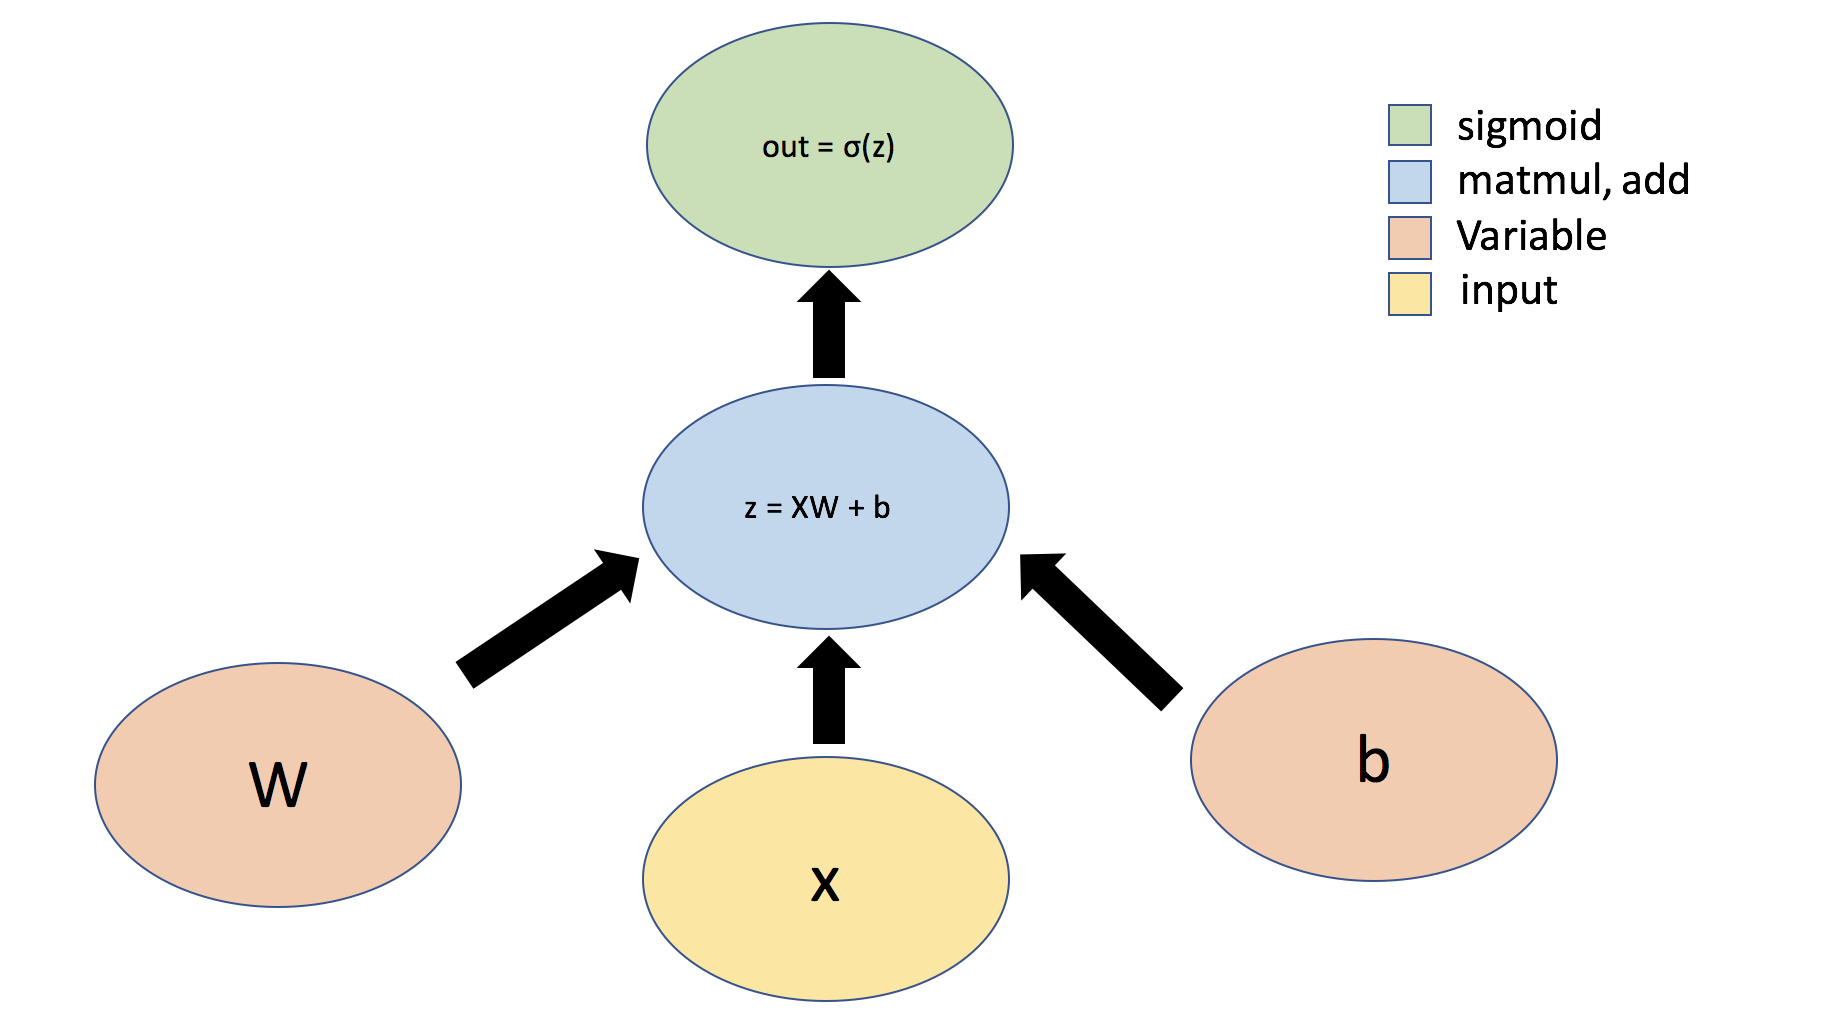

We will use torch.nn.Module to define layers -- the building blocks of neural networks. Layers implement common neural networks operations. In PyTorch, when we implement a layer, we subclass nn.Module and define the parameters of the layer as attributes of our new class. We also define and override a function forward, which will define the forward pass computation that is performed at every step. All classes subclassing nn.Module should override the forward function.

In [9]:
# defining a dense layer

# num_inputs: number of input nodes
# num_outputs: number of output nodes
# x: input to the layer

class OurDenseLayer(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(OurDenseLayer, self).__init__()
        # Define and initialize parameters: a weight matrix W and bias b
        # Note that the parameter intialization is random
        self.W= torch.nn.Parameter(torch.randn(num_inputs, num_outputs))
        self.bias= torch.nn.Parameter(torch.randn(num_outputs))

    def forward(self, x):
        z= torch.matmul(x, self.W)
        y= torch.sigmoid(z+ self.bias)
        return y

Now lets test the output of our layer

In [10]:
# define a layer and test the output
num_inputs= 2
num_outputs= 3
layer= OurDenseLayer(num_inputs, num_outputs)
x_input= torch.tensor([[1, 2.0]])
y= layer(x_input)

print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.5387, 0.5136, 0.6377]], grad_fn=<SigmoidBackward0>)


Conveniently, PyTorch has defined a number of nn.Modules (or Layers) that are commonly used in neural networks, for example a nn.Linear or nn.Sigmoid module.

Now, instead of using a single Module to define our simple neural network, we'll use the nn.Sequential module from PyTorch and a single nn.Linear layer to define our network. With the Sequential API, you can readily create neural networks by stacking together layers like building blocks.

In [11]:
# defining a nn using the PyTorch Sequential API

# define the number of inputs and outputs
n_input_nodes= 2
n_output_nodes= 3

# define the model
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=3),  # Dense (Linear) layer
    nn.Sigmoid()  # Non-linearity
)

We've defined our model using the Sequential API. Now, we can test it out using an example input:

In [12]:
# test the model with example input 
x_input= torch.tensor([[1, 2.0]])
y= model(x_input)
print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.5051, 0.7702, 0.8598]], grad_fn=<SigmoidBackward0>)
